In [2]:
import os
import wget
import zipfile
from os.path import exists
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

In [3]:
bean_data_file= "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base= "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number= "00602"
if not exists(bean_data_file):
    filename="DryBeanDataset.zip"
    url = base + dataset_number+"/"+ filename
    wget.download(url)
    with zipfile.ZipFile(filename,"r") as zip_ref:
        zip_ref.extractall("./")
        os.remove(filename)

# bad model  

In [4]:
#read excel file
beans = pd.read_excel(bean_data_file)
#Labels are characters that needs to be converted to integer for sklearn
le= LabelEncoder()
beans["Class"]= le.fit_transform(beans["Class"])
# split data into classification target and feature
y= beans["Class"]
X = beans.drop("Class",axis=1)
#split of training data
X_train,X_rest1,y_train,y_rest1= train_test_split(X,y,train_size=10000,random_state=22)
#split of rest data in 2 groups

X_test,X_rest2,y_test,y_rest2= train_test_split(X_rest1,y_rest1, train_size=1000,random_state=42)

#split remaining in calibration data and "new" data for the conformal prediction step and for evaluating the conformal predictor

X_calib,X_new,y_calib,y_new= train_test_split(X_rest2,y_rest2, train_size=1000,random_state=33)

#fit the model
model= GaussianNB().fit(X_train,y_train)


In [5]:
type(y_new)

pandas.core.series.Series

In [6]:
#check accuracy
y_pred = model.predict(X_test)
print(f"Accuracy: {(y_pred== y_test).mean()}")
#crreate confusion matrix
cm= confusion_matrix(y_test,y_pred)
print(pd.DataFrame(cm,index= le.classes_,columns= le.classes_))

Accuracy: 0.743
          BARBUNYA  BOMBAY  CALI  DERMASON  HOROZ  SEKER  SIRA
BARBUNYA        36       0    53         0     13      0     2
BOMBAY           0      32     0         0      0      0     0
CALI            33       0    96         0      5      0     1
DERMASON         0       0     0       210      0     30    10
HOROZ            3       0     4         3    109      0    21
SEKER            2       0     0        24      0    114    18
SIRA             0       0     0         7     17     11   146


# first try: a naive approach to improve the model

In [7]:
predictions= model.predict_proba(X_calib)
#get for each instance the highest probability
high_prob_predictions= np.amax(predictions,axis=1)
#select only those where the probability is  over 95%
high_p_beans= np.where(high_prob_predictions>=0.95)
#let's count how often we hit the right label
its_a_match= (model.predict(X_calib)==y_calib)
coverage= np.mean(its_a_match.values[high_p_beans])
print(round(coverage,3))

0.92


# second attempt : conformal classification

0.92!= 0.95 wrong coverage.  instead of using the model probabilities we use the model prediction to build a measure of uncertainty:

s_i= 1- f(x_i)[y_i]

a notation that mean that we take 1 minus the probability of the true class. This is known as the non-conformity score and measure how unusual a suggested outcome is given the model output for x_i.
to decide which of the conformal predictions are "conformal", conformal prediction calculates a treshold based on the non-conformity scores of the calibration data in combination with the true labels.
the sequence is like this:
1. start with the data not used for training
2. Calculate the scores s_i
3. sort the scores from low (certain) to high (uncertain)
4. compute the threshold $\hat q$ where 95% of the s_i are smaller (= 95% quantile)


In [8]:
n = len(X_calib)
#get the probability predictions
predictions= model.predict_proba(X_calib)
#we only need the probability for the true class
prob_true_class= predictions[np.arange(n),y_calib]
scores= 1- prob_true_class
#set the alpha so that 1-alpha is 0.95
alpha= 0.05
#define quantile
q_level= np.ceil((n+1)*(1-alpha))/n
qhat= np.quantile(scores,q_level, method="higher")

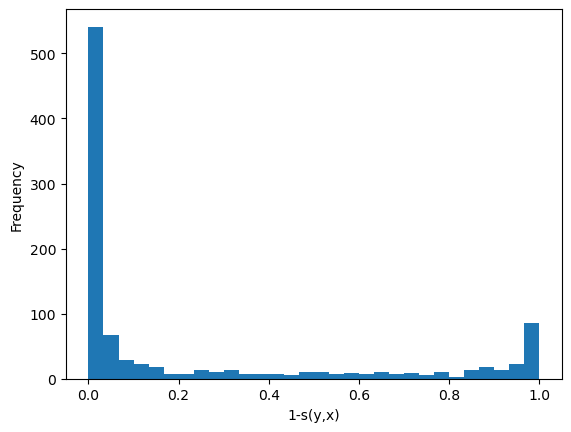

In [9]:
#matplotlib plot

#get the probabilities from the model
predictions=model.predict_proba(X_calib)
#get for each instance the actual probability of the ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]
plt.hist(1-prob_for_true_class,bins=30,range=(0,1))
plt.xlabel("1-s(y,x)")
plt.ylabel("Frequency")
plt.show()

In [10]:
predictions_sets= (1-model.predict_proba(X_new)<=qhat)
for i in range(3):
    print(le.classes_[predictions_sets[i]])

['HOROZ' 'SIRA']
['SIRA']
['BARBUNYA' 'CALI']


On average, the prediction sets cover the true class with a probability of 95%

# MAPIE
MAPIE is a python library for conformal prediction

## metodo score

In [11]:
from mapie.classification import MapieClassifier
cp= MapieClassifier(estimator= model,cv="prefit",method="score")
cp.fit(X_calib,y_calib)
y_pred,y_set=  cp.predict(X_new,alpha=0.05) #provide an array to alpha if you want to see the prediction sets for different values of alpha
print(np.shape(y_set))
y_set=np.squeeze(y_set)
print(np.shape(y_set))

(1611, 7, 1)
(1611, 7)


In [12]:
for i in range(5):
    print(le.classes_[y_set[i]])

['HOROZ' 'SIRA']
['SIRA']
['BARBUNYA' 'CALI']
['SEKER']
['BOMBAY']


In [13]:
#count number of classes per bean
set_sizes= y_set.sum(axis=1)
print(set_sizes)
#use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

[2 1 2 ... 3 2 1]
2    789
1    678
3    144
Name: count, dtype: int64


In [14]:
#use a pandas dataframe to hold the results

y_pred,y_set= cp.predict(X_new,alpha=0.05)
y_set= np.squeeze(y_set)
df= pd.DataFrame()
for i in range(len(y_pred)):
    predset= le.classes_[y_set[i]]
    temp_df= pd.DataFrame({"set":[predset],"setsize":[len(predset)]},index=[i])
    df=pd.concat([df,temp_df])

In [15]:
print(df.head())

                set  setsize
0     [HOROZ, SIRA]        2
1            [SIRA]        1
2  [BARBUNYA, CALI]        2
3           [SEKER]        1
4          [BOMBAY]        1


## naive method

In [16]:
mapie_score= MapieClassifier(model,cv="prefit",method= "naive")
mapie_score.fit(X_train,y_train)
y_pred,y_set= mapie_score.predict(X_new,alpha=0.05)
y_set= np.squeeze(y_set)

In [17]:
cov= classification_coverage_score(y_new,y_set)
setsize= classification_mean_width_score(y_set)
print(f"Coverage:{cov: .2%}/n Average set size: {setsize: .2f}")

Coverage: 89.45%/n Average set size:  1.39


the coverage is too low because the scores in the training date are not suitable for finding the threshold $\hat q$ . the model is too overconfident and therefore the coverage is too low for new data.

### check coverage by class

In [18]:
def class_wise_performance(y_new,y_set,classes):
    df= pd.DataFrame()
    for i in range(len(classes)):
        ynew= y_new.values[y_new.values==i]
        yscore = y_set[y_new.values==i]
        cov= classification_coverage_score(ynew,yscore)
        size= classification_mean_width_score(yscore)

        temp_df=pd.DataFrame({"class":[classes[i]],"coverage":[cov],"avg. set size":[size]},index=[i])

        df=pd.concat([df,temp_df])
    return(df)

In [19]:
print(class_wise_performance(y_new,y_set,le.classes_))

      class  coverage  avg. set size
0  BARBUNYA  0.830065       1.732026
1    BOMBAY  1.000000       1.000000
2      CALI  0.911111       1.577778
3  DERMASON  0.922353       1.244706
4     HOROZ  0.840816       1.351020
5     SEKER  0.887967       1.448133
6      SIRA  0.903974       1.380795


## aps (adaptive prediction sets) method in MAPIE

In [20]:
mapie_score= MapieClassifier(model, cv="prefit",method ="cumulated_score",random_state=1)
mapie_score.fit(X_calib,y_calib)

MapieClassifier(cv='prefit', estimator=GaussianNB(), method='cumulated_score',
                random_state=1)

### last label included

In [21]:
y_pred, y_set = mapie_score.predict(X_new,alpha=0.05,include_last_label=True)
y_set= np.squeeze(y_set)
#check convergence
cov= classification_coverage_score(y_new,y_set)
setsize= classification_mean_width_score(y_set)
print(f"Coverage:{cov: .2%}/n Average set size: {setsize: .2f}")
print(class_wise_performance(y_new,y_set,le.classes_))

Coverage: 95.59%/n Average set size:  1.81
      class  coverage  avg. set size
0  BARBUNYA  0.954248       2.111111
1    BOMBAY  1.000000       1.000000
2      CALI  0.966667       2.105556
3  DERMASON  0.964706       1.491765
4     HOROZ  0.922449       1.783673
5     SEKER  0.962656       1.987552
6      SIRA  0.950331       1.993377


### last label excluded

In [22]:
y_pred, y_set = mapie_score.predict(X_new,alpha=0.05,include_last_label=False)
y_set= np.squeeze(y_set)
#check convergence
cov= classification_coverage_score(y_new,y_set)
setsize= classification_mean_width_score(y_set)
print(f"Coverage:{cov: .2%}/n Average set size: {setsize: .2f}")
print(class_wise_performance(y_new,y_set,le.classes_))

Coverage: 80.51%/n Average set size:  1.13
      class  coverage  avg. set size
0  BARBUNYA  0.529412       1.124183
1    BOMBAY  1.000000       1.000000
2      CALI  0.800000       1.105556
3  DERMASON  0.905882       1.145882
4     HOROZ  0.759184       1.167347
5     SEKER  0.726141       1.087137
6      SIRA  0.864238       1.149007


### include last label at random

In [23]:
y_pred, y_set = mapie_score.predict(X_new,alpha=0.05,include_last_label="randomized")
y_set= np.squeeze(y_set)
#check convergence
cov= classification_coverage_score(y_new,y_set)
setsize= classification_mean_width_score(y_set)
print(f"Coverage:{cov: .2%}/n Average set size: {setsize: .2f}")
print(class_wise_performance(y_new,y_set,le.classes_))

Coverage: 94.72%/n Average set size:  1.78
      class  coverage  avg. set size
0  BARBUNYA  0.954248       2.117647
1    BOMBAY  1.000000       2.000000
2      CALI  0.961111       2.094444
3  DERMASON  0.948235       1.428235
4     HOROZ  0.910204       1.738776
5     SEKER  0.950207       1.834025
6      SIRA  0.950331       1.837748


## top-k method for fixed size sets

the top-k method was introduced by angelopoulos et al in 2020. it follows the same conformal classification recipe as APS and the score method but uses a different non-conformity score. Top-k uses only the rank of the true class instead of the probability outcome. Thee higher the rank of the true class, the less certain the model classification was. As a consequence, all the prediction sets have the same size, with the expection of cases were multiple classes have the same probability, in that case the set consider all of them together, thus leading to some set having a higher number of classes than the threshold.
furthermore, since top-k method can only cut at distinct points, the coverage will not be exactly 1- $\alpha$

In [24]:
mapie_score= MapieClassifier(model, cv="prefit",method ="top_k",random_state=1)
mapie_score.fit(X_calib,y_calib)
y_pred, y_set = mapie_score.predict(X_new,alpha=0.05,include_last_label="randomized")
y_set= np.squeeze(y_set)
#check convergence
cov= classification_coverage_score(y_new,y_set)
setsize= classification_mean_width_score(y_set)
print(f"Coverage:{cov: .2%}/n Average set size: {setsize: .2f}")
print(class_wise_performance(y_new,y_set,le.classes_))

Coverage: 98.63%/n Average set size:  3.52
      class  coverage  avg. set size
0  BARBUNYA  0.980392       3.418301
1    BOMBAY  1.000000       7.000000
2      CALI  0.994444       3.555556
3  DERMASON  1.000000       3.960000
4     HOROZ  0.959184       3.000000
5     SEKER  0.975104       3.000000
6      SIRA  0.993377       3.000000


## Regularized APS or RAPS
the aps method tend to produce rather large prediction sets, especially of there are more than a handful of possible classes because there is the possibility that there is a long tail of classes with low probability. RAPS fixes this problem by introducting regularization. The regularization is based on 2 parameters $\lambda$ and $k_{reg}$. All classes with a rank higher than $k_{reg}$  get a penalty term proportional to $lambda$. Such penalty term is realized in the form of an additional probability that is added to the pseudo probability given by the model

In [25]:
mapie_score= MapieClassifier(model, cv="prefit",method ="raps",random_state=1)
mapie_score.fit(X_calib,y_calib,size_raps=0.2)## notice the new keyword size_raps
y_pred, y_set = mapie_score.predict(X_new,alpha=0.05,include_last_label="randomized")
y_set= np.squeeze(y_set)
#check convergence
cov= classification_coverage_score(y_new,y_set)
setsize= classification_mean_width_score(y_set)
print(f"Coverage:{cov: .2%}/n Average set size: {setsize: .2f}")
print(class_wise_performance(y_new,y_set,le.classes_))

Coverage: 94.72%/n Average set size:  1.82
      class  coverage  avg. set size
0  BARBUNYA  0.954248       2.045752
1    BOMBAY  1.000000       2.000000
2      CALI  0.961111       2.077778
3  DERMASON  0.945882       1.449412
4     HOROZ  0.910204       1.746939
5     SEKER  0.954357       1.950207
6      SIRA  0.950331       1.996689


## Group balanced conformal prediction
APS and RAPS  get you closer to conditional coverage  when compared to either the native method or the score method, but by now mean they assure that coverage holds for every data point or subset of data points. In the case when we have a specific group of data for which we want to guarantee coverage we can use group-balanced conformal prediction.
The idea behind group-balaned conformal prediction is to divide the data into groups and perform the conformal prediction separately for each group. This requires that you know the groups before predictions, so it doesn't work if we want to split by the feature that we want to predict (ie, classes). One side effect of this technique is that the calibration data must be split by the number of groups upon which we want to apply conformal prediction. This means that if we have few data points in total, each group's calibration set may become too small and unreliable.
As an example, let's apply group-conformal prediction to all the beans whose area is smalle than 70000.

d:\Users\Pasqu\anaconda3\envs\conform\Lib\site-packages\mapie\classification.py:1031: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 7 unique labels while calibration have 6 unique labels
  warnings.warn(


MapieClassifier(cv='prefit', estimator=GaussianNB(), method='score')

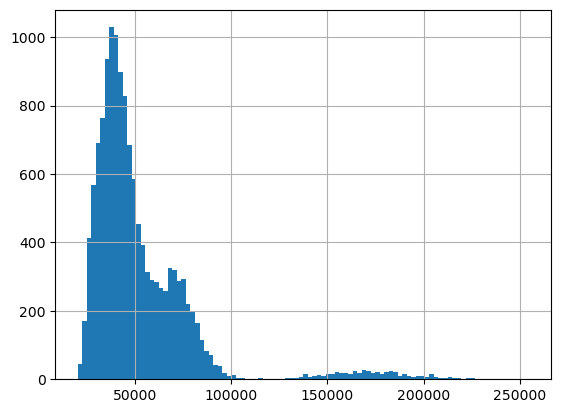

In [26]:
X.Area.hist(bins=100)
small_bean_index= X_calib.Area<70000
X_calib_group= X_calib[small_bean_index]
y_calib_group= y_calib[small_bean_index]
mapie_group= MapieClassifier(model,cv="prefit",method="score")
mapie_group.fit(X_calib_group,y_calib_group)

In [27]:
group_index= X_new.Area < 70000
X_group = X_new[group_index]
y_pred,y_set = mapie_group.predict(X_group,alpha=0.05)
print(mapie_group.quantiles_)


[0.99730024]


## Class-conditional APS (CCAPS) for coverage by class
CCAPS is an approach to guarantee 1-$alpha$ coverage of prediction sets per class. This is a useful proerty to have in many cases, as it makes the conformal prediction much more adaptive and gives equal attention to each class,bypassing the problem of class imbalance.
The calibration step is the same as for group-balanced conformal prediction, and we use class as the grouping variable.
In the prediction step instead we don't know the true classes for the new data. The solution, given by Derhacobian et al(2020), consists in applying all resulting classes conformal predictions, and then the prediction set is the union of all conformal classes. This translate in picking the highest quantile threshold among those calculated per class. This choice guarantee that we have a coverage of $>= 1-\alpha$. However, this also means that for some classes the coverage is much higher, thus producing large prediction sets.

In [28]:
# grouping classes
groups_dict= {}
for i in range(1,len(le.classes_)):
    groups_dict[i] = (X_calib[y_calib.values==i],y_calib[y_calib.values==i])



In [29]:
# grouping classes
quantiles=[]
sets = []
for i in range(1,len(le.classes_)):
    mapie_group= MapieClassifier(model,cv="prefit",method="score")
    mapie_group.fit(groups_dict[i][0],groups_dict[i][1] )
    y_pred,y_set = mapie_group.predict(X_new,alpha=0.05)
    sets.append(np.squeeze(y_set))
    quantiles.append(mapie_group.quantiles_[0])
print(max(quantiles))

0.9996367204988864


d:\Users\Pasqu\anaconda3\envs\conform\Lib\site-packages\mapie\classification.py:1031: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 7 unique labels while calibration have 1 unique labels
  warnings.warn(
d:\Users\Pasqu\anaconda3\envs\conform\Lib\site-packages\mapie\classification.py:1031: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 7 unique labels while calibration have 1 unique labels
  warnings.warn(
d:\Users\Pasqu\anaconda3\envs\conform\Lib\site-packages\mapie\classification.py:1031: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 7 unique labels while calibration have 1 unique labels
  warnings.warn(
d:\Users\Pasqu\anaconda3\envs\conform\Lib\site-packages\mapie\classification.py:1031: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 7 unique labels while ca

In [30]:
result = np.logical_or.reduce(sets, axis=0)
cov= classification_coverage_score(y_new,result)
setsize= classification_mean_width_score(result)
print(f"Coverage:{cov: .2%}/n Average set size: {setsize: .2f}")
print(class_wise_performance(y_new,result,le.classes_))

Coverage: 96.21%/n Average set size:  1.91
      class  coverage  avg. set size
0  BARBUNYA  0.967320       2.176471
1    BOMBAY  1.000000       1.000000
2      CALI  0.972222       2.150000
3  DERMASON  0.971765       1.557647
4     HOROZ  0.934694       1.922449
5     SEKER  0.966805       2.157676
6      SIRA  0.950331       2.142384


## Guide for conformal prediction  in classification problems

the author make some raccomendations about what criteria use depending on our necessities:

- we need fixed prediction sets -> use top-k
- we don't care about conditional coverage-> score method since it's the simpliest (excluding the naive method which doesn't work)
- we don't care about conditional coverage as long as the coverage per group is guaranteed-> either group-balanced conformal prediction or (APS and RAPS), depending if we have enough data or not.
- we don't care about conditional coverage as long as each class has guaranteed coverage-> APS or RAPS, depending if we have few classes(APS) or not.
